##### Combine tags, combine text columns, regex, lemmatize, stem, stopwords, save to csv, reread csv and drop nulls, model

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [46]:
full_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kivamix.csv')

In [47]:
full_kiva = full_kiva[['LOAN_ID', 'COUNTRY_NAME', 'STATUS', 'DESCRIPTION_TRANSLATED', 'LOAN_USE', 'TAGS']]

In [48]:
kiva = full_kiva[full_kiva['COUNTRY_NAME']=='Kenya']

In [49]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  50025 non-null  object
 4   LOAN_USE                50025 non-null  object
 5   TAGS                    43157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [50]:
kiva['STATUS'].value_counts(normalize=True)

1    0.784659
0    0.215341
Name: STATUS, dtype: float64

In [51]:
# filling nulls with blank spaces so they aren't erased when combined
kiva = kiva.fillna(' ')

In [52]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51170 non-null  object
 4   LOAN_USE                51170 non-null  object
 5   TAGS                    51170 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [53]:
# removing spaces within tags and creating new column w/changes to TAGS
kiva['processed_TAGS'] = [row.replace(' ', '') for row in kiva['TAGS']]

In [54]:
# removing dashes within tags 
kiva['processed_TAGS'] = [row.replace('-', '') for row in kiva['processed_TAGS']]

In [55]:
# creating column with all text included
kiva['all_text'] = (kiva['DESCRIPTION_TRANSLATED']+kiva['LOAN_USE']+kiva['processed_TAGS'])

In [56]:
# removing html breaks
kiva['all_text'] = kiva['all_text'].str.replace('<br />', ' ')

In [76]:
kiva['all_text'][30]

'Harriet is a married woman and she has three children. She describes herself to be honest. She operates a hotel. She has been involved in this business for 16 years. Her business is located in a good area and her primary customers are locals. She describes her biggest business challenge to be inadequate working capital.   She will use the KES 98,000 loan to buy furniture for the hotel use. She hopes that in the future, she will have more outlets.to buy furniture for the hotel use.#BizDurableAsset,#Parent,#WomanOwnedBusiness'

In [96]:
# Removing punctuation from text
tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
kiva['all_text'] = [tokenizer.tokenize(row.lower()) for row in kiva['all_text']]

In [97]:
# removing s's from ends of words to be able to count singulars and plurals together
lemmatizer = WordNetLemmatizer()
kiva['all_text'] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in kiva['all_text']]

In [98]:
# removing most common english words from text
kiva['all_text'] = [[token for token in token_list if token not in stopwords.words('english')] for token_list in kiva['all_text']]

In [101]:
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [102]:
# stemming words in all_text 
kiva['all_text'] = [[p_stemmer.stem(token) for token in token_list] for token_list in kiva['all_text']]

In [103]:
kiva.isnull().sum()

index                     0
LOAN_ID                   0
COUNTRY_NAME              0
STATUS                    0
DESCRIPTION_TRANSLATED    0
LOAN_USE                  0
TAGS                      0
processed_TAGS            0
all_text                  0
dtype: int64

In [104]:
kiva.to_csv('/Users/precious/dsi/Group-Project/kiva_kenya_processed.csv', index=False)

In [105]:
new_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kiva_kenya_processed.csv')

In [106]:
new_kiva.isnull().sum()

index                        0
LOAN_ID                      0
COUNTRY_NAME                 0
STATUS                       0
DESCRIPTION_TRANSLATED       0
LOAN_USE                     0
TAGS                         0
processed_TAGS            8013
all_text                     0
dtype: int64

In [107]:
X = new_kiva['all_text']
y = new_kiva['STATUS']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [109]:
y.value_counts(normalize=True)

1    0.784659
0    0.215341
Name: STATUS, dtype: float64

In [115]:
tvec = TfidfVectorizer(ngram_range=(1,2))
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [116]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tvec, y_train)

LogisticRegression(max_iter=1000)

In [114]:
# scoring logistic regression (ngram1,2, max_feat20_000
print(f'Train score: {logreg.score(X_train_tvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tvec, y_test)}')

Train score: 0.8422232066081247
Test score: 0.8197451731415618


In [117]:
# scoring logistic regression (ngram1,2, max_feat20_000
print(f'Train score: {logreg.score(X_train_tvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tvec, y_test)}')

Train score: 0.84803397868515
Test score: 0.8209176893613696


In [118]:
# creating predictions from test data
logreg_preds = logreg.predict(X_test_tvec)

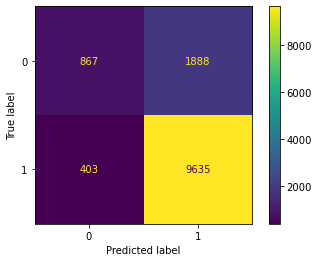

In [119]:
# showing predictions vs true status where 0=expired and 1=funded
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm).plot();

In [120]:
print(f'ROC AUC: {roc_auc_score(y_test, logreg_preds)}')

ROC AUC: 0.6372765523677901


In [121]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.68      0.31      0.43      2755
           1       0.84      0.96      0.89     10038

    accuracy                           0.82     12793
   macro avg       0.76      0.64      0.66     12793
weighted avg       0.80      0.82      0.79     12793



In [122]:
# creating dataframe of coefs
word_coef_df = pd.DataFrame({'coefs': logreg.coef_[0], 'features': tvec.get_feature_names()})

In [123]:
# top 20 features and their coefficients
word_coef_df.nlargest(20, 'coefs')

,coefs,features
1089,5.987298,20 000
253024,3.695260,user_favorit
1088,3.687187,20
2519,3.658070,30 000
128079,3.630529,ke 20
260573,3.621709,widow
227839,3.150060,singl mother
227898,2.943348,singlepar
2518,2.506864,30
128095,2.447734,ke 30


In [124]:
# lowest 20 features and their coefficients
word_coef_df.nsmallest(20, 'coefs')

,coefs,features
361,-4.711812,100
362,-4.546071,100 000
151035,-4.285213,man
208221,-3.484122,repairrenewreplac
208382,-3.386652,repeatborrow
225260,-3.007196,shop
173654,-2.847293,nhe
634,-2.812549,150 000
633,-2.792020,150
128047,-2.779488,ke 100
